<a href="https://colab.research.google.com/github/mitkrieg/UTransformer/blob/main/utransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
repo = '/content/drive/MyDrive/GitHub/UTransformer'
sys.path.append(repo)
!pip install tensorboardX

In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/scenery6000.zip'
extract_path = '/content/scenery6000'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/scenery6000


In [3]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Resize, CenterCrop
import os
from os.path import join
from models.build4 import build_model, ImagePool
#from models.Generator_former import Generator_former
from utils.loss import IDMRFLoss
from models.Discriminator_ml import MsImageDis
#from utils.utils import gaussian_weight
from tensorboardX import SummaryWriter
from dataset import dataset_norm
import argparse
from datetime import datetime
from torch.utils.data import Dataset,DataLoader,TensorDataset
# this version is with normlized input with mean and std, all layers are normalized,
# change the order of the 'make_layer' with norm-activate-conv,and use the multi-scal D
# use two kind feature, horizon and vertical

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# Training
def train(gen, dis, opt_gen, opt_dis, epoch, train_loader, writer):
    gen.train()
    dis.train()

    #mse = nn.MSELoss().cuda(0)
    mae = nn.L1Loss().cuda(0)
    mrf = IDMRFLoss(device=0)

    acc_pixel_rec_loss = 0
    acc_feat_rec_loss = 0
    acc_mrf_loss = 0
    acc_feat_cons_loss = 0
    acc_gen_adv_loss = 0
    acc_dis_adv_loss = 0

    for batch_idx, (gt, mask_img) in enumerate(train_loader):

        batchSize = mask_img.shape[0]
        imgSize = mask_img.shape[2]

        #gt, mask_img, iner_img = Variable(gt).cuda(0), Variable(mask_img.type(torch.FloatTensor)).cuda(0), Variable(iner_img).cuda(0)
        gt, mask_img = Variable(gt).cuda(0), Variable(mask_img.type(torch.FloatTensor)).cuda(0)
        iner_img = gt[:, :, 32:32 + 128, 32:32 + 128]
        #I_groundtruth = torch.cat((I_l, I_r), 3)  # shape: B,C,H,W

        ## Generate Image
        I_pred, f_de = gen(mask_img)
        #I_pred = gen(mask_img)
        f_en = gen(iner_img, only_encode=True)

        # i_mask = torch.ones_like(gt)
        # i_mask[:, :, 32:32 + 128, 32:32 + 128] = 0
        # mask_pred = I_pred * i_mask
        mask_pred = I_pred[:, :, 32:32 + 128, 32:32 + 128]


        ## Compute losses
        ## Update Discriminator
        opt_dis.zero_grad()
        dis_adv_loss = dis.calc_dis_loss(I_pred.detach(), gt)
        dis_loss = dis_adv_loss
        dis_loss.backward()
        opt_dis.step()

        # Pixel Reconstruction Loss
        #pixel_rec_loss = mse(I_pred, gt) * 10
        #pixel_rec_loss = mse(mask_pred, iner_img) * 10
        pixel_rec_loss = mae(I_pred, gt) * 20

        # Texture Consistency Loss (IDMRF Loss)
        #mrf_loss = mrf(((I_pred * img_mask).cuda(0) + 1) / 2.0, ((gt * img_mask).cuda(0) + 1) / 2.0) * 0.01 / batchSize
        mrf_loss = mrf((mask_pred.cuda(0) + 1) / 2.0, (iner_img.cuda(0) + 1) / 2.0) * 0.5 / batchSize
        # mrf_loss = mrf((I_pred_split[1].cuda(1)+1)/2.0, (I_m.cuda(1)+1)/2.0) * 0.01

        # Feature Reconstruction Loss
        #feat_rec_loss = mse(f_all, f_all_gt.detach()).mean() * batchSize
        #feat_rec_loss = mse(f_all, f_all_gt.detach()) * 5
        feat_rec_loss = mae(f_de, f_en.detach())

        # ## Update Generator
        gen_adv_loss = dis.calc_gen_loss(I_pred, gt)
        #gen_loss = pixel_rec_loss + gen_adv_loss + mrf_loss.cuda(0) + feat_rec_loss
        gen_loss = pixel_rec_loss + gen_adv_loss + feat_rec_loss + mrf_loss.cuda(0)
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        acc_pixel_rec_loss += pixel_rec_loss.data
        acc_gen_adv_loss += gen_adv_loss.data
        acc_mrf_loss += mrf_loss.data
        acc_feat_rec_loss += feat_rec_loss.data
        #acc_feat_cons_loss += feat_cons_loss.data
        acc_dis_adv_loss += dis_adv_loss.data

        if batch_idx % 10 == 0:
            print("train iter %d" % batch_idx)
            print('generate_loss:', gen_loss.item())
            print('dis_loss:', dis_loss.item(

            ))

    ## Tensor board
    writer.add_scalars('train/generator_loss',
                       {'Pixel Reconstruction Loss': acc_pixel_rec_loss / len(train_loader.dataset)}, epoch)
    writer.add_scalars('train/generator_loss', {'Texture Consistency Loss': acc_mrf_loss / len(train_loader.dataset)},
                       epoch)
    writer.add_scalars('train/generator_loss',
                       {'Feature Reconstruction Loss': acc_feat_rec_loss / len(train_loader.dataset)}, epoch)
    #writer.add_scalars('train/generator_loss', {'Feature Consistency Loss': acc_feat_cons_loss / len(train_loader.dataset)}, epoch)
    writer.add_scalars('train/generator_loss', {'Adversarial Loss': acc_gen_adv_loss / len(train_loader.dataset)},
                       epoch)
    writer.add_scalars('train/discriminator_loss', {'Adversarial Loss': acc_dis_adv_loss / len(train_loader.dataset)},
                       epoch)

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
SAVE_WEIGHT_DIR = f'{repo}/checkpoints/former_resize_4-3/'
SAVE_LOG_DIR = f'{repo}/logs_all/logs_former_resize_4-3/'
TRAIN_DATA_DIR = f'/content/scenery6000/scenery/all'
LOAD_WEIGHT_DIR = '/content/vgg19_weights.pth'

In [5]:
config = {}
config['pre_step'] = 1
config['TYPE'] = 'swin'
config['IMG_SIZE'] = 224
config['SWIN.PATCH_SIZE'] = 4
config['SWIN.IN_CHANS'] = 3
config['SWIN.EMBED_DIM'] = 96
config['SWIN.DEPTHS'] = [2, 2, 6, 2]
config['SWIN.NUM_HEADS'] = [3, 6, 12, 24]
config['SWIN.WINDOW_SIZE'] = 7
config['SWIN.MLP_RATIO'] = 4.
config['SWIN.QKV_BIAS'] = True
config['SWIN.QK_SCALE'] = None
config['DROP_RATE'] = 0.0
config['DROP_PATH_RATE'] = 0.2
config['SWIN.PATCH_NORM'] = True
config['TRAIN.USE_CHECKPOINT'] = False

args = {}
args['save_weight_dir'] = SAVE_WEIGHT_DIR
args['log_dir'] = SAVE_LOG_DIR
args['train_data_dir'] = TRAIN_DATA_DIR
args['load_weight_dir'] = LOAD_WEIGHT_DIR
args['train_batch_size'] = 40
args['test_batch_size'] = 16
args['epochs'] = 300
args['lr'] = 2e-4
args['load_pretrain'] = False
args['test_flag'] = False
args['adjoint'] = True

In [6]:


# import torchvision.models as models

# # Load the pre-trained VGG19 model
# vgg19 = models.vgg19(pretrained=True)

# # Access the model's state dictionary
# vgg19_weights = vgg19.state_dict()

# torch.save(vgg19_weights, 'vgg19_weights.pth')


In [ ]:
pred_step = 1
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
os.makedirs(args['save_weight_dir'], exist_ok=True)
os.makedirs(args['log_dir'], exist_ok=True)
writer = SummaryWriter(join(args['log_dir'], 'SR_Stage_4%s' % datetime.now().strftime("%Y%m%d-%H%M%S")))

# Initialize the model
print('Initializing model...')
gen = build_model(config).cuda()
#gen = Generator7(pred_step, device=0).cuda(0)
dis = MsImageDis().cuda()
#fake_pool = ImagePool(500)
#real_pool = ImagePool(500)

opt_gen = optim.Adam(gen.parameters(), lr=args['lr'] / 2, betas=(0, 0.9), weight_decay=1e-4)
opt_dis = optim.Adam(dis.parameters(), lr=args['lr'] * 2, betas=(0, 0.9), weight_decay=1e-4)

# Load pre-trained weight
if args['load_pretrain']:
    print('Loading model weight...at epoch 140')
    gen.load_state_dict(torch.load(join(args['load_weight_dir'], 'Gen_former_500')))
    dis.load_state_dict(torch.load(join(args['load_weight_dir'], 'Dis_former_500')))

# Load data
print('Loading data...')
#transformations = transforms.Compose([ToTensor(), Normalize(mean, std)])
transformations = transforms.Compose([Resize(192), CenterCrop(192), ToTensor(), Normalize(mean, std)])
#train_data = torch.load(args.train_data_dir)
#train_dataset = TensorDataset(train_data['gt'], train_data['mask'], train_data['iner'])
#train_dataset = TensorDataset(train_data['gt'], train_data['mask'])
#train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.train_batch_size, shuffle=True)
train_data = dataset_norm(root=args['train_data_dir'], transforms=transformations, imgSize=192, inputsize=128)
train_loader = DataLoader(train_data, batch_size=args['train_batch_size'], shuffle=True)
print('train data: %d images' % (len(train_loader.dataset)))
# if args.test_flag:
#     test_data = dataset_around(root=args.test_data_dir, transforms=transformations, crop='center', imgSize=128)
#     test_loader = DataLoader(test_data, batch_size=args.test_batch_size, shuffle=False)
#     print('test data: %d images' % (len(test_loader.dataset)))

# Train & test the model
for epoch in range(0, 1 + args['epochs']):
    print("----Start training[%d]----" % epoch)
    #train(gen, dis, fake_pool, real_pool, opt_gen, opt_dis, epoch, train_loader, writer)
    train(gen, dis, opt_gen, opt_dis, epoch, train_loader, writer)
    # if args.test_flag:
    #     print("----Start testing[%d]----" % epoch)
    #     test(gen, dis, epoch, test_loader, writer)

    # Save the model weight
    if (epoch % 20) == 0:
        torch.save(gen.state_dict(), join(args['save_weight_dir'], 'Gen_former_%d' % epoch))
        torch.save(dis.state_dict(), join(args['save_weight_dir'], 'Dis_former_%d' % epoch))

writer.close()


Initializing model...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading data...
train data: 5800 images
----Start training[0]----


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train iter 0
generate_loss: 37.03340148925781
dis_loss: 64.45760345458984
train iter 10
generate_loss: 21.265058517456055
dis_loss: 7.55183744430542
train iter 20
generate_loss: 18.81904411315918
dis_loss: 6.513623237609863
train iter 30
generate_loss: 19.33749771118164
dis_loss: 7.008969783782959
train iter 40
generate_loss: 16.41029167175293
dis_loss: 6.468441009521484
train iter 50
generate_loss: 16.143383026123047
dis_loss: 6.551087379455566
train iter 60
generate_loss: 15.562403678894043
dis_loss: 6.452979564666748
train iter 70
generate_loss: 15.374618530273438
dis_loss: 6.481708526611328
train iter 80
generate_loss: 14.565199851989746
dis_loss: 6.154663562774658
train iter 90
generate_loss: 14.267412185668945
dis_loss: 6.736931800842285
train iter 100
generate_loss: 14.718385696411133
dis_loss: 6.064157485961914
train iter 110
generate_loss: 13.716113090515137
dis_loss: 6.038981914520264
train iter 120
generate_loss: 15.282744407653809
dis_loss: 6.044578552246094
train iter 130


In [31]:
x = next(iter(train_loader))
x

[tensor([[[[ 0.8745,  0.8902,  0.9059,  ...,  1.0000,  1.0000,  1.0000],
           [ 0.8745,  0.8980,  0.9137,  ...,  1.0000,  1.0000,  1.0000],
           [ 0.8745,  0.8980,  0.9137,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 0.1686,  0.1373,  0.1216,  ..., -0.1922, -0.2549, -0.2941],
           [ 0.1686,  0.0510,  0.0039,  ...,  0.0118,  0.0431,  0.0353],
           [ 0.1608,  0.1294,  0.0902,  ...,  0.0039,  0.0353,  0.0667]],
 
          [[ 1.0000,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 0.0980,  0.0275,  0.0039,  ..., -0.2000, -0.2549, -0.2706],
           [ 0.0980, -0.0353, -0.0902,  ...,  0.0588,  0.0902,  0.0745],
           [ 0.0902,  0.0824,  0.0588,  ...,  0.0667,  0.0980,  0.1216]],
 
          [[ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
           [ 

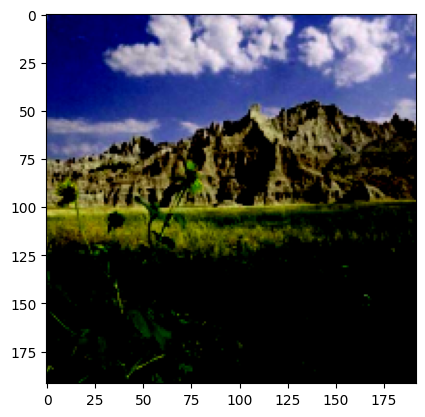

In [38]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(x[0][1].permute(1,2,0).cpu().numpy())